ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

Ran `pip install netCDF4`

# Guide to Climatology Baseline Analysis Script  

**Purpose:**  
Evaluate **Mean Absolute Error (MAE)**, **False Alarm Rate (FAR)**, and **Miss Rate (MR)** for the **climatology baseline** of monsoon onset forecasts against IMD observations.  
This benchmark defines the “zero-skill” reference used to compare deterministic and probabilistic AI forecast performance in the AICE evaluation framework.  

---

## Summary  
- **Objective:** Quantify the performance of climatological mean onset forecasts using IMD rainfall as ground truth.  
- **Core Metrics:**  
  - **MAE:** Average difference (in days) between climatological and observed onset.  
  - **FAR:** Fraction of false early onsets.  
  - **MR:** Fraction of observed onsets missed by the baseline.  
- **Scope:** Multi-year, multi-grid evaluation using the Modified **Moron–Robertson (MR)** onset rule and optional **MOK (June 2)** filtering.

---

### Context  
The climatology baseline serves as the simplest forecast benchmark within the **AICE Monsoon Onset Evaluation Suite**, alongside the deterministic and probabilistic model assessments.  
Using the **Modified Moron–Robertson** agronomic onset rule and the **Median Onset over Kerala (MOK)** filter, it translates theoretical onset definitions into an operational benchmark that mirrors real forecast cycles.  

---

## Script Details  

### Data Flow  

**Inputs:**  
- **Rainfall Observations:** Daily 1° × 1° IMD rainfall grids.  
- **Thresholds:** Mean wet-spell threshold file (`mwset2x2.nc4`) generated via `imd_onset_threshold.py`.  
- **Shapefile:** India boundary polygon for plotting and CMZ averaging.

**Process:**  
1. Detect observed onsets (MR + optional MOK filter).  
2. Compute climatological mean onset day-of-year (DOY).  
3. Treat climatology as forecast for each initialization date.  
4. Compare with observed onsets within defined tolerance windows.  
5. Compute MAE, FAR, and MR per grid point.  
6. Aggregate multi-year maps and generate 3-panel plots.  

**Outputs:**  
- **NetCDF Metric Files:**  
  - `output/climatology_1-15day_mok.nc`  
  - `output/climatology_16-20day_noMOK.nc`  
  - `output/climatology_16-30day_mok_long.nc`  
- **Figures:**  
  Saved in `output/plots/` — three-panel PNG maps visualizing MAE, FAR, and MR with CMZ overlays.  
- **Logs:**  
  Processing summaries and runtime diagnostics under `output/logs/`.  

---

### Functions  

- `load_imd_rainfall()` — Load and standardize IMD rainfall data.  
- `detect_observed_onset()` — Apply MR onset logic to compute observed onset.  
- `compute_climatological_onset()` — Derive the multi-year mean onset.  
- `get_initialization_dates()` — Generate Mon/Thu initialization dates per year.  
- `compute_climatology_as_forecast()` — Apply climatology as the forecast baseline.  
- `compute_climatology_metrics_with_windows()` — Derive MAE, FAR, and MR metrics.  
- `create_spatial_far_mr_mae()` — Aggregate spatially and compute annual means.  
- `plot_spatial_metrics()` — Visualize MAE, FAR, MR panels with CMZ averages.  

---

## Parameters  

| Parameter | Description | Typical Value |
|------------|-------------|----------------|
| `--years` | Evaluation years | 2019–2024 |
| `--imd_folder` | IMD rainfall directory | `./data/imd/2p0` |
| `--thres_file` | MWmean threshold | `./threshold/mwset2x2.nc4` |
| `--tolerance_days` | Allowed deviation | 3 (1–15 day) / 5 (16–30 day) |
| `--verification_window` | Start day of verification window | 1 |
| `--forecast_days` | Forecast window length | 15 or 30 |
| `--max_forecast_day` | Max forecast step | 15 or 30 |
| `--mok` | Apply MOK (June 2) filter | on/off |
| `--shpfile_path` | India shapefile for visualization | `./india_shp/india.shp` |
| `--output_file`, `--plot_dir` | Output destinations | `./output/metrics.nc`, `./output/plots/` |

---

## CLI Examples  

**Scenario 1 — 1–15 Day Forecast (MOK Enabled)**  

```bash
python mae_far_mr_climatology.py \
    --years 2019 2020 2021 2022 2023 2024 \
    --imd_folder ./data/imd/2p0 \
    --thres_file ./threshold/mwset2x2.nc4 \
    --tolerance_days 3 \
    --verification_window 1 \
    --forecast_days 15 \
    --mok \
    --output_file ./output/climatology_1-15day_mok.nc \
    --plot_dir ./output/plots
```

**Scenario 2 — 16–20 Day Forecast (No MOK)**

```bash
python mae_far_mr_climatology.py \
    --years 2019 2020 2021 2022 2023 2024 \
    --imd_folder ./data/imd/2p0 \
    --thres_file ./threshold/mwset2x2.nc4 \
    --tolerance_days 5 \
    --verification_window 16 \
    --forecast_days 20 \
    --output_file ./output/climatology_16-20day_noMOK.nc \
    --plot_dir ./output/plots
```

**Scenario 3 — 16–30 Day Long-Range Forecast (MOK Enabled)**

```bash
python mae_far_mr_climatology.py \
    --years 2019 2020 2021 2022 2023 2024 \
    --imd_folder ./data/imd/2p0 \
    --thres_file ./threshold/mwset2x2.nc4 \
    --tolerance_days 5 \
    --verification_window 16 \
    --forecast_days 30 \
    --mok \
    --output_file ./output/climatology_16-30day_mok_long.nc \
    --plot_dir ./output/plots
```

## Output  

**NetCDF Metrics:**  
Stored in `./output/` (one per forecast window).  

**Visualizations:**  
PNG maps under `./output/plots/` (each showing MAE, FAR, and MR panels).  

**Example Findings:**  
- CMZ MAE ≈ 4 ± 0.5 days  
- FAR ≈ 25–30 %  
- MR ≈ 28–35 %  

---

## Validation Checks  

- IMD and MWmean grids share identical spatial resolution.  
- Initialization dates correspond to each evaluation year (not hard-coded).  
- MOK filtering consistently applied in both observation and forecast evaluation.  
- CMZ polygon automatically chosen for correct grid spacing (1°, 2°, 4°).  

---

## Common Pitfalls  

- Mismatch in grid alignment between IMD and threshold files.  
- Hard-coded 2024 init-date logic (should use each year).  
- Name shadowing between `matplotlib.path.Path` and `pathlib.Path`.  
- Zero-division in FAR/MR metrics if some years lack valid onsets.  

---

## Figures

To regenerate results and plots, run:  
```bash
python mae_far_mr_climatology.py \
  --years 2019 2020 2021 2022 2023 2024 \
  --imd_folder ./data/imd/2p0 \
  --thres_file ./threshold/mwset2x2.nc4 \
  --tolerance_days 3 \
  --forecast_days 15 \
  --mok \
  --output_file ./output/climatology_1-15day_mok.nc \
  --plot_dir ./output/plots
```


# CODE BELOW 

In [ ]:
import subprocess
from pathlib import Path

from IPython.display import Image, display

In [2]:
base_cmd = [
    "python",
    "mae_far_mr_climatology.py",
    "--imd_folder",
    "../../imd_rainfall_data/2p0",
    "--thres_file",
    "../../imd_onset_threshold/mwset2x2.nc4",
    "--shpfile_path",
    "../../ind_map_shpfile/india_shapefile.shp",
    "--plot_dir",
    "./output/plots",
]

log_dir = Path("./output/logs")
log_dir.mkdir(parents=True, exist_ok=True)
scenario_logs = {}
scenario_summaries = {}

In [ ]:
def run_and_capture(name: str, extra_args: list[str], log_key: str) -> str:
    """Run a command with extra arguments, capture its output, save to log file, and print."""
    cmd = base_cmd + extra_args
    log_path = log_dir / f"{log_key}.log"
    print(f"Running {name}\n{'-' * (8 + len(name))}")
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)  # noqa: S603
    log_text = result.stdout
    log_path.write_text(log_text)
    print(log_text)
    print(f"\nFull log saved to: {log_path}\n")
    return log_text

### Scenario 1 – Early verification window with MOK filter
Run the climatology baseline for 2018–2020 focusing on the 1–15 day window and enforcing the MOK (June 2) onset constraint to check early-lead performance.

Running Scenario 1 – Early window, MOK
--------------------------------------
Processing years: [2018, 2019, 2020]
IMD folder: ../../imd_rainfall_data/2p0
Threshold file: ../../imd_onset_threshold/mwset2x2.nc4
Shapefile path: ../../ind_map_shpfile/india_shapefile.shp
Tolerance days: 3
Verification window: 1
Forecast days: 15
Max forecast day: 15
MOK filter: True
Output file: output/climatology_1-15day_mok.nc
Plot directory: ./output/plots
Figure size: [18, 6]
Computing climatological onset reference...
Computing climatological onset from 124 years: 1901-2024
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1901.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1901-06-02) as start date for onset detection
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1902.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1902-06-02) as start date for onset detection
L

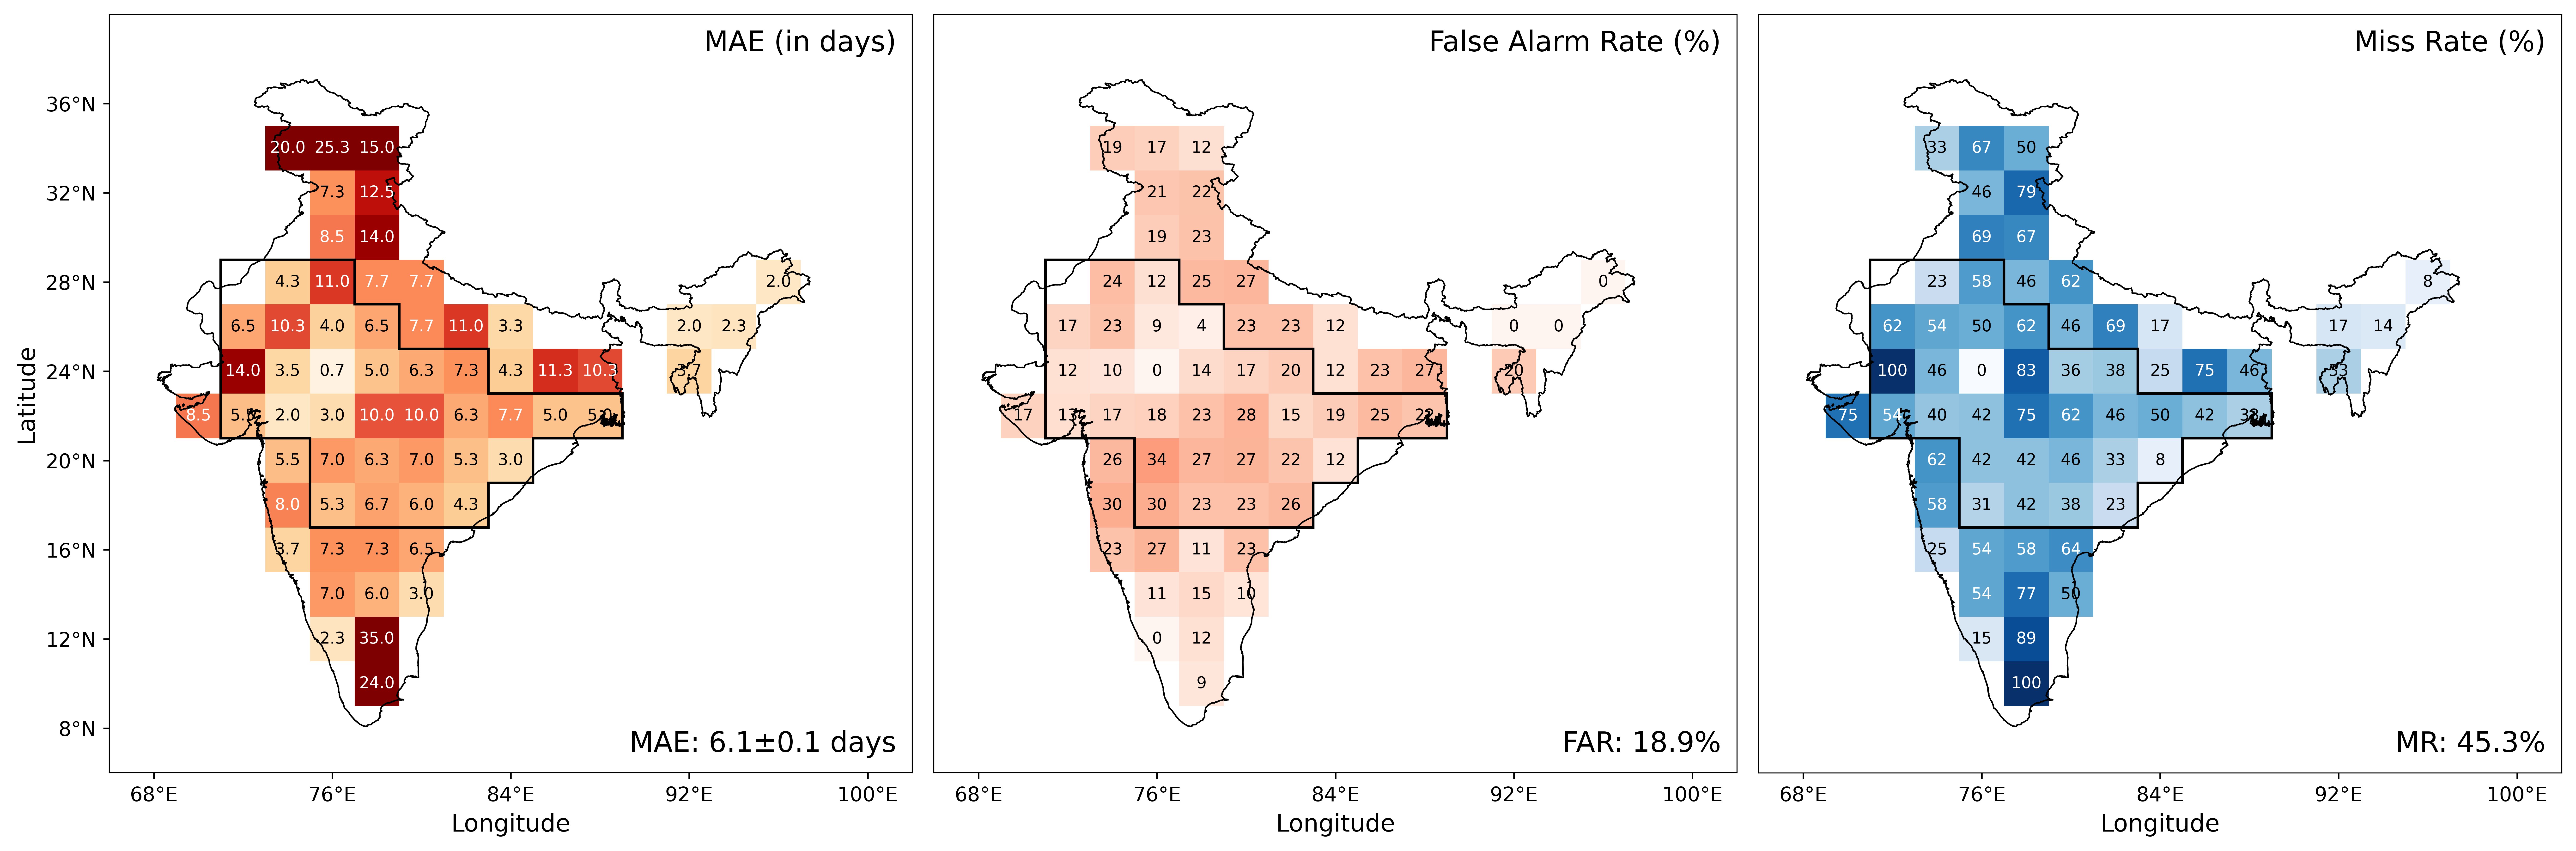

In [ ]:
scenario_key = "climatology_1_15day_mok"
output_file = Path("./output/climatology_1-15day_mok.nc")
plot_file = Path("./output/plots/climatology_spatial_metrics_2018-2020_1-15day_MOK.png")

log_text = run_and_capture(
    "Scenario 1 – Early window, MOK",
    [
        "--output_file",
        str(output_file),
        "--years",
        "2018",
        "2019",
        "2020",
        "--tolerance_days",
        "3",
        "--verification_window",
        "1",
        "--forecast_days",
        "15",
        "--max_forecast_day",
        "15",
        "--mok",
    ],
    log_key=scenario_key,
)

display(Image(filename=str(plot_file)))

### Analysis
- Existing log `output/logs/climatology_1_15day_mok.log` confirms the 2018–2020 run completed with Mean MAE 7.83 days, FAR 17.8%, and Miss Rate 48.6% (CMZ MAE 6.09 ± 0.13 days).
- The spatial plots show MAE hotspots (>15 days) over northwest India while the CMZ remains around 5–8 days, indicating the climatology baseline stays close to onset timing over the core zone but diverges sharply in arid fringe grids.
- FAR stays comparatively low because the tight 1–15 day verification window plus the MOK (June 2) start suppress late initializations, yet the same filter drives the high miss rates—log diagnostics note only ~21% of potential initializations produce forecasts.
- Early-lead usage of climatology therefore yields conservative alarms that seldom arrive in time for eastern coastal grids; users should interpret the product as biased toward late declarations rather than outright false alarms in this configuration.

### Scenario 2 – Extended window with MOK filter
Repeat the baseline for 2010–2015 over the 16–30 day verification window while keeping the MOK start constraint to evaluate deeper lead times.

Running Scenario 2 – Long window, MOK
-------------------------------------
Processing years: [2010, 2011, 2012, 2013, 2014, 2015]
IMD folder: ../../imd_rainfall_data/2p0
Threshold file: ../../imd_onset_threshold/mwset2x2.nc4
Shapefile path: ../../ind_map_shpfile/india_shapefile.shp
Tolerance days: 5
Verification window: 16
Forecast days: 30
Max forecast day: 30
MOK filter: True
Output file: output/climatology_16-30day_mok_long.nc
Plot directory: ./output/plots
Figure size: [18, 6]
Computing climatological onset reference...
Computing climatological onset from 124 years: 1901-2024
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1901.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1901-06-02) as start date for onset detection
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1902.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1902-06-02) as start dat

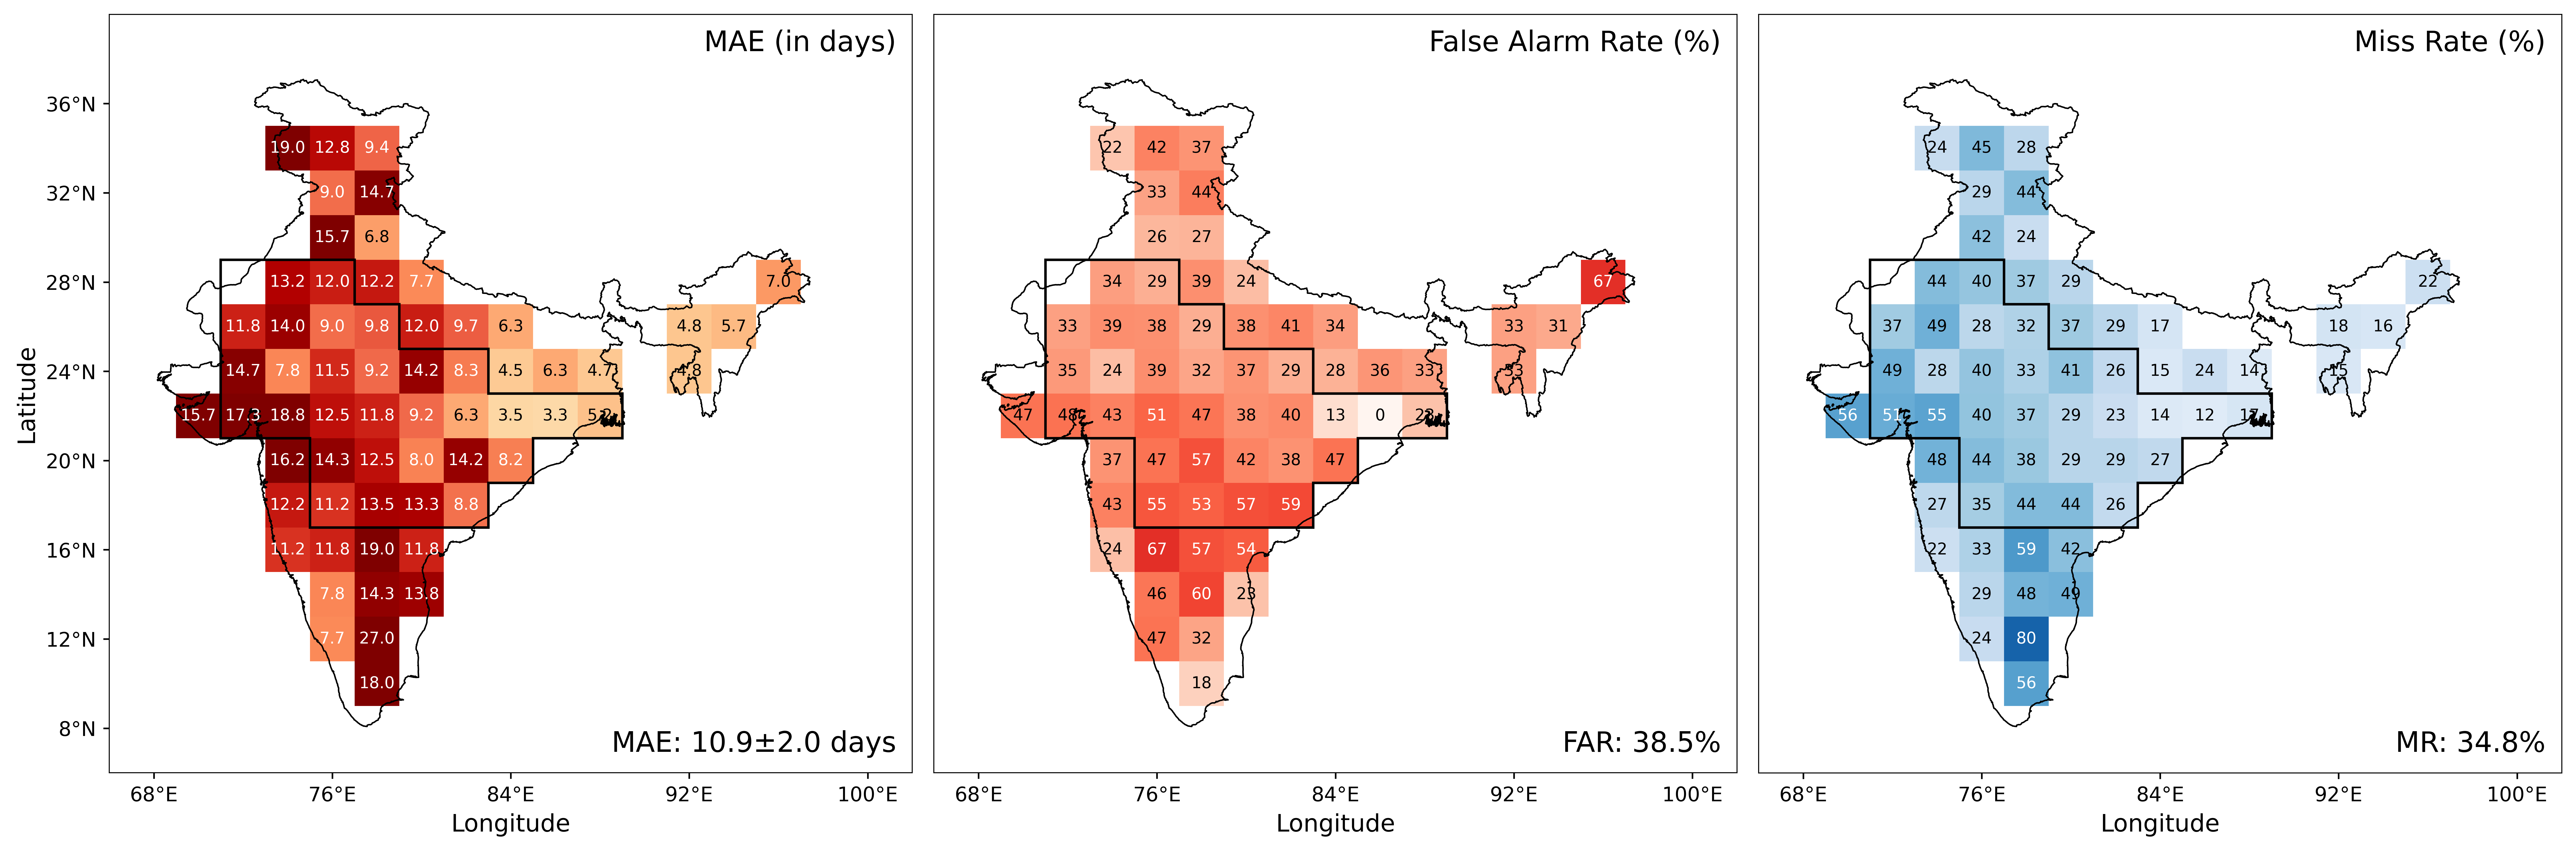

In [5]:
scenario_key = "climatology_16_30day_mok"
output_file = Path("./output/climatology_16-30day_mok_long.nc")
plot_file = Path(
    "./output/plots/climatology_spatial_metrics_2010-2015_16-30day_MOK.png"
)

log_text = run_and_capture(
    "Scenario 2 – Long window, MOK",
    [
        "--output_file",
        str(output_file),
        "--years",
        "2010",
        "2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "--tolerance_days",
        "5",
        "--verification_window",
        "16",
        "--forecast_days",
        "30",
        "--max_forecast_day",
        "30",
        "--mok",
    ],
    log_key=scenario_key,
)

display(Image(filename=str(plot_file)))

### Analysis
- Log `output/logs/climatology_16_30day_mok.log` reports Mean MAE 11.08 days, FAR 38.3%, Miss Rate 34.3%, and CMZ MAE 10.92 ± 2.01 days—substantially worse than the early-window case.
- Extending the verification window to 16–30 days while retaining the MOK filter roughly doubles the forecast rate (~0.48–0.52 of potential inits) and inflates false alarms; the FAR panel is universally >30% with coastal Assam reaching 67%.
- MAE errors exceed 10 days across most of central India and CMZ, signalling that climatology drifts well ahead of observed onset when the forecast window is stretched.
- Despite the longer lead, miss rates drop relative to Scenario 1 because more late-season initializations survive the MOK gate, but the broad high FAR implies the baseline over-activates and offers limited actionable value at extended lead.

### Scenario 3 – Mid-range window without MOK
Remove the MOK start-date constraint for 2015–2018 and cap forecasts at day 20 to check sensitivity to the initialization filter.

Running Scenario 3 – Mid window, no MOK
---------------------------------------
Processing years: [2015, 2016, 2017, 2018]
IMD folder: ../../imd_rainfall_data/2p0
Threshold file: ../../imd_onset_threshold/mwset2x2.nc4
Shapefile path: ../../ind_map_shpfile/india_shapefile.shp
Tolerance days: 4
Verification window: 16
Forecast days: 30
Max forecast day: 20
MOK filter: False
Output file: output/climatology_16-20day_noMOK.nc
Plot directory: ./output/plots
Figure size: [18, 6]
Computing climatological onset reference...
Computing climatological onset from 124 years: 1901-2024
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1901.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using May 1st (1901-05-01) as start date for onset detection
Loading IMD rainfall from: ../../imd_rainfall_data/2p0/data_1902.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using May 1st (1902-05-01) as start date for onset detection
Loading IMD 

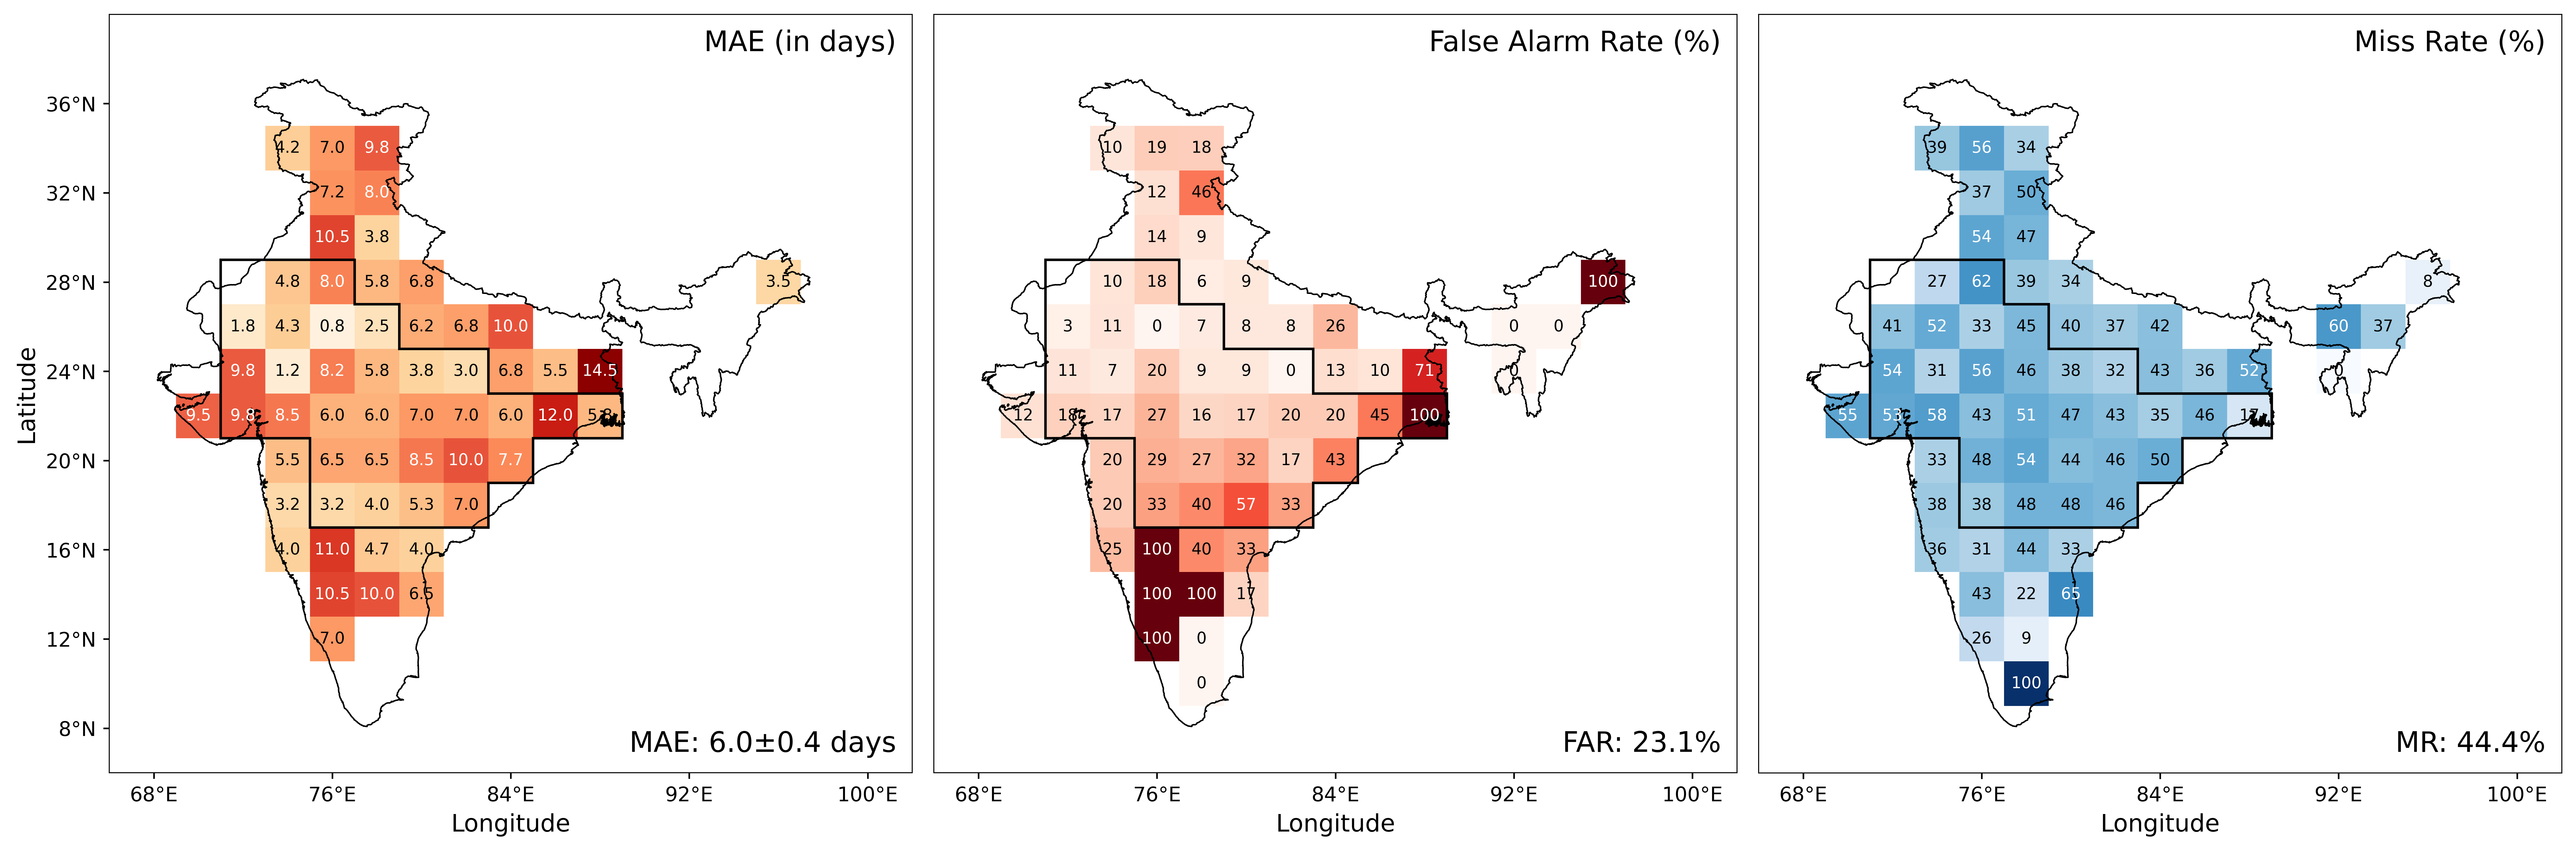

In [6]:
scenario_key = "climatology_16_20day_noMOK"
output_file = Path("./output/climatology_16-20day_noMOK.nc")
plot_file = Path(
    "./output/plots/climatology_spatial_metrics_2015-2018_16-30day_noMOK.png"
)

log_text = run_and_capture(
    "Scenario 3 – Mid window, no MOK",
    [
        "--output_file",
        str(output_file),
        "--years",
        "2015",
        "2016",
        "2017",
        "2018",
        "--tolerance_days",
        "4",
        "--verification_window",
        "16",
        "--forecast_days",
        "30",
        "--max_forecast_day",
        "20",
    ],
    log_key=scenario_key,
)

display(Image(filename=str(plot_file)))

### Analysis
- Without the MOK constraint (`output/logs/climatology_16_20day_noMOK.log`), the 2015–2018 run attains the lowest Mean MAE (6.54 days) and CMZ MAE 5.98 ± 0.45 days, while FAR climbs to 26.5% and Miss Rate moderates to 42.2%.
- Allowing May 1 starts increases valid initializations (~0.36–0.39 forecast rate) and recovers some early onsets, reducing misses versus Scenario 1 but exposing coastal Tamil Nadu/Gujarat grids to 100% FAR because climatology now triggers before actual onset.
- MAE values over the CMZ tighten to 4–8 days, showcasing modest skill retention mid-season even without the June 2 gate, though pockets in northeast India remain >10 days.
- The trade-off is a noisier alarm product: stakeholders gain timelier detection in the central belt at the expense of frequent false starts along coastal extremes.